# Scorecard reader
You need some folders to run this:
* scorecards_path - path to folder with the scorecards you want analyzed
* merged_path - temporary folder which stores images before OCR
* merged_analyzed_path - folder which stores images after OCR
* flagged_path - contains all scorecards which we could use OCR on for whatever reason
* analyzed_path - all scorecards which are not flagged will be put here

### OCR
We're using the microsoft azure document intelligence to do the OCR.
It takes images up to 4mb and returns all text (computer generated and hand written)

### How it works
1. Preprocess and merge scorecards from scorecards_path into fewer images (~40 scorecards per image). For each scorecard, the relevant information is cut out and put horisontally in a wide image. This includes event, round, competitor ID, and the 6 result boxes (5 + extra). If an image can't be identified, it will be moved into "flagged_path". The merged image consists of a bunch of these horisontal scorecards stacked vertically, along with an identifier "<!>" at the start of each line. If a scorecard can't be correctly identified, it will not be included in the merge. The function that does this stores the merged images in "merged_path", and returns a list of which scorecards are used.
2. Send the merged images for OCR, move the images from "merged_path" to "merged_analyzed_path"
3. Structure the analyzed images. We can loop through the results from the OCR and each line of text will contain text from each "box" in the merged image. The identifier "<!>" will be used to mark a new result, which is then followed by event, round, competitor ID, and the 6 result boxes. These are stored in a list, which itself is stored in a bigger list. This list is returned as "results_list".
4. Now, "scorecards_path" and "results_list" contain the same information, and we save each scorecard as (unique_id)\_(event)\_(round)\_id(competitor_id).jpg and a json file with the same name. The json file contains the information from results_list in a format that can be sent to WCA Live.

In [1]:
%run supporting_functions.py

line_identifier = "<!>"
main_path = fr"C:\Users\ulrik\Desktop\Kubing\Python\Scorecards"


In [6]:
# save the information above in a file called "competition_info.json" with the following format:
main_path = fr"C:\Users\ulrik\Desktop\Kubing\Python\Scorecards"

# read the json file and save the information in variables
with open(fr"{main_path}\competition_info.json", "r") as f:
    competition_info = json.load(f)
competition = competition_info["competition"]
wca_live_token = competition_info["wca_live_token"]
key = competition_info["azure_key"]
scorecards_path = competition_info["scorecards_path"]


Competition: test_competition
WCA Live token: -
Azure key: 5cab6ca1e11842e38a662eea78853e38
Scorecards path: C:\Users\ulrik\Desktop\Kubing\Python\Scorecards\scorecards


In [11]:
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential

# Set up your credentials and endpoint
endpoint = "https://norwayeastdoctest.cognitiveservices.azure.com/"

merged_path = main_path + fr"\merged\temp" # merged images are put here before they are analyzed
merged_analyzed_path = main_path + fr"\merged\merged_analyzed" # merged images are put here after they are analyzed
analyzed = main_path + fr"\analyzed" # analyzed images are put here after they are analyzed

# make sure the folders exist
for path in [merged_path, merged_analyzed_path, analyzed]:
    if not os.path.exists(path):
        os.makedirs(path)

if not os.path.exists(os.path.join(analyzed, competition)):
    os.mkdir(os.path.join(analyzed, competition))

flagged_path = os.path.join(analyzed, competition, "flagged")
if not os.path.exists(os.path.join(analyzed, competition, "flagged")):
    os.mkdir(flagged_path)

analyzed_path = os.path.join(analyzed, competition, "analyzed")
if not os.path.exists(analyzed_path):
    os.mkdir(analyzed_path)

if not os.path.exists(os.path.join(analyzed, competition, "sorted")): # we will not use this path, but it is created for sorting the analyzed scorecards with the double checking program
    os.mkdir(os.path.join(analyzed, competition, "sorted"))

In [18]:
with open(os.path.join(main_path, "event_to_id.json"), "r") as f:
    event_to_id = json.load(f)

with open(os.path.join(main_path, "event_id_max_time_allowed_cs.json"), "r") as f:
    event_id_max_time_allowed_cs = json.load(f)

In [4]:
def merge_scorecards(scorecards_path, flagged_path, merged_path, group_size = 40, downscale_factor = 0.7, compress_original = True):
    stacked_ID_images = stack_n_images(group_size)
    all_scorecard_paths = get_all_image_paths(scorecards_path)
    merged_scorecard_paths = []
    top_right_coords_list = []
    
    if all_scorecard_paths:
        i = -1
        j = len(get_all_image_paths(merged_path))
        full_image = 0
        for scorecard_path in all_scorecard_paths:
            next_scorecard, top_right_coords = scorecard_to_horisontal(scorecard_path, compress_original = compress_original)

            # if it could not load it properly, next_scorecard will be an int. Move to flagged folder
            # if it is loaded properly we save the path to the scorecard
            if isinstance(next_scorecard, int):
                shutil.move(scorecard_path, os.path.join(flagged_path, os.path.basename(scorecard_path)))
                continue
            else:
                merged_scorecard_paths += [scorecard_path]
                top_right_coords_list += [top_right_coords]

            if i == -1: # if first scorecards (i = -1)
                full_image = next_scorecard
                i += 1

            elif i == 0: # if first scorecard of new group (i = 0)
                # save merged image

                # make sure the merged image name is unique, pad with zeros
                merged_image_name = f'merged{j:04}.jpg'
                j += 1
                merged_image_path = os.path.join(merged_path, merged_image_name)

                # add stacked_ID_images to the left side of the full image
                stacked_ID_images = stacked_ID_images[:full_image.shape[0],:,:]
                full_image = np.hstack([stacked_ID_images,full_image])

                # Downscale the image
                new_width = int(full_image.shape[1] * (downscale_factor))
                new_height = int(full_image.shape[0] * (downscale_factor))
                full_image = cv2.resize(full_image, (new_width, new_height))
                
                cv2.imwrite(merged_image_path, full_image)

                # reset full image
                full_image = next_scorecard

            else: # if i > 0, add to merged image
                # add scorecard to merged image
                dimensions = next_scorecard.shape
                border = np.ones((100, dimensions[1], 3), dtype=np.uint8) * 255
                
                full_image = np.vstack([full_image,border,next_scorecard])

            i = (i + 1) % group_size

        # save last image
        # make sure the merged image name is unique
        merged_image_name = f'merged{j:04}.jpg'
        merged_image_path = os.path.join(merged_path, merged_image_name)

        # add stacked_ID_images to the left side of the full image
        stacked_ID_images = stacked_ID_images[:full_image.shape[0],:,:]
        full_image = np.hstack([stacked_ID_images,full_image])

        # Downscale the image
        new_width = int(full_image.shape[1] * (downscale_factor))
        new_height = int(full_image.shape[0] * (downscale_factor))
        full_image = cv2.resize(full_image, (new_width, new_height))
        
        cv2.imwrite(merged_image_path, full_image)

    return merged_scorecard_paths, top_right_coords_list

In [5]:
def read_merged_image(merged_image_path):
    # Create a Form Recognizer client
    form_recognizer_client = FormRecognizerClient(endpoint, AzureKeyCredential(key))
    # Use the client to analyze the form
    with open(merged_image_path, "rb") as f:
        poller = form_recognizer_client.begin_recognize_content(f.read())
    result = poller.result()
    return result

def stats_from_merged_images(merged_path, merged_analyzed_path):
    files = os.listdir(merged_path)
    k = len(os.listdir(merged_analyzed_path))
    results = []
    
    if files:
        # make sure we loop through the files in the correct order, meaning merged0001.jpg first, then merged0002.jpg etc.
        files.sort(key=lambda f: int(re.sub('\D', '', f)))
        for i, image in enumerate(files):
            image_path = os.path.join(merged_path, image)
            results.append(read_merged_image(image_path))
            shutil.move(image_path, os.path.join(merged_analyzed_path, f'merged_analyzed{i:04}.jpg'))
    return results

In [6]:
import concurrent.futures

def read_merged_image(merged_image_path):
    # Create a Form Recognizer client
    form_recognizer_client = FormRecognizerClient(endpoint, AzureKeyCredential(key))
    # Use the client to analyze the form
    with open(merged_image_path, "rb") as f:
        poller = form_recognizer_client.begin_recognize_content(f.read())
    result = poller.result()
    return result

def analyze_and_move_image(image_path, merged_analyzed_path, index):
    result = read_merged_image(image_path)
    shutil.move(image_path, os.path.join(merged_analyzed_path, f'merged_analyzed{index:04}.jpg'))
    return result

def stats_from_merged_images(merged_path, merged_analyzed_path):
    files = os.listdir(merged_path)
    k = len(os.listdir(merged_analyzed_path))
    results = []

    if files:
        # Ensure correct order
        files.sort(key=lambda f: int(re.sub('\D', '', f)))

        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Use executor.map to parallelize the requests
            results = list(executor.map(
                lambda args: analyze_and_move_image(*args),
                [(os.path.join(merged_path, image), merged_analyzed_path, i) for i, image in enumerate(files)]
            ))

    return results

In [7]:
def structure_attempt(attempt, event_id = "222", time_to_cs = True): 
    # TODO: Log changes, return them (to see what actually happens to the time)
    flag = False
    
    if "/" in attempt:
        flag = True
    
    # remove and non-digit and non-alpha characters
    attempt = re.sub(r'[^a-zA-Z0-9.,+:=/-]', '', attempt)
    
    # +2/+4/...       
    if "=" in attempt:
        attempt = attempt.split("=")[-1]
    if "-" in attempt: # interpret - as =
        attempt = attempt.split("-")[-1]
    
    # change / to 1
    attempt = attempt.replace("/", "1") # TODO: test both 1 and ,
    
    # if text in result, we change to DNF or DNS (doesnt matter which, we can fix this when double checking)
    if any(char.isalpha() for char in attempt):
        if "EX" in attempt:
            flag = True # flag extras
            attempt = "ex" # we deal with extra later
        elif "S" in attempt:
            attempt = "-2"
        else:
            attempt = "-1"
        return attempt, flag
    
    # make sure the format is mm:ss.cs
    
    # change , and : to .
    attempt = attempt.replace(",", ".")
    attempt = attempt.replace(":",".")
        
    # change mm:ss:cs to mm:ss.cs
    if attempt.count(".") > 1:
        colon_indices = [i for i, char in enumerate(attempt) if char == '.']
        attempt = attempt[:colon_indices[0]] + ':' + attempt[colon_indices[0] + 1:]
    
    # if no . in time, return 0 and flag
    if "." not in attempt:
        if len(attempt)>4 or len(attempt)<3:
            attempt = "0"
            flag = True
            return attempt, flag
        else: # unless 4 or 3 we flag and insert a .
            attempt = attempt[:len(attempt)-2]+"."+attempt[-2:]
            flag = True
    
    # remove 1's from the beginning if it's due to the box
    if ":" in attempt:
        if len(attempt.split(":")[0])>1 and attempt[0] == "1":
            attempt = attempt[1:]
    elif "." in attempt:
        if len(attempt.split(".")[0])>2 and attempt[0] == "1":
            attempt = attempt[1:]
    if len(attempt.split("."))>1 and len(attempt.split(".")[1])<2:
        attempt += "9"
        flag = True # if a digit is missing after the last .
    if attempt[0] == ":": # damage control
        attempt = "1"+attempt    
    
    # convert time to cs
    
    m, s, cs = "0", "0", "0"
    try:
        if ":" in attempt:
            m, scs = attempt.split(":")
            s, cs = scs.split(".")
        else:
            s, cs = attempt.split(".")
    except:
        return "0", True

    if len(m)>2 or len(s)>2 or len(cs)>3:
        attempt = "0"
        flag = True
        return attempt, flag
    
    # make sure cs is 2 decimals only
    cs = cs[:2]
    try:
        attempt_in_cs = str(6000*int(m) + 100*int(s) + int(cs))
    except:
        attempt = "0"
        flag = True
        return attempt, flag
    
    # Use event type to flag/skip unreasonable times (sub 4 for 3x3 for example)
    if int(attempt_in_cs) < int(event_id_max_time_allowed_cs[event_id]):
        attempt = "0"
        attempt_in_cs =  "0"
    
    if attempt == "0":
        flag = True
        
    if time_to_cs:
        return attempt_in_cs, flag
    return attempt, flag

In [8]:
def fix_results_list(results_list):
    # make sure the results list is valid, i.e. has the format [event, round, competitor_id, attempt1, attempt2, attempt3, attempt4, attempt5]
    # if not, we make event 333, round 1, competitor_id 0, and the rest 0

    # if last attempt is "ex", we change it to 0
    if len(results_list) and results_list[-1] == "ex":
        results_list[-1] = 0
        
    # if "ex" in results_list, we change the ex to the last attempt and remove the last attempt
    if "ex" in results_list:
        results_list[results_list.index("ex")] = results_list[-1]
        results_list.pop()

    if len(results_list) > 8:
        results_list = results_list[:8]
    if len(results_list) < 8:
        results_list += [0 for i in range(8-len(results_list))]

    # if we don't have the correct type for the first element, we save it as unknown
    if not isinstance(results_list[0], str):
        results_list[0] = "unknown"
    
    return results_list

def structure_results(results):
    # takes a list of results from read_merged_image and returns a list of lists of attempts
    structured_results = []
    results_list = []
    i = 0

    for res in results:
        for page in res:
            for line in page.lines:
                text = line.text.upper()
                text = text.replace("×","X") # sometimes x's is written as ×

                # if "..." in text we skip it as it's not relevant
                if "..." in text:
                    continue

                # if the text is the identifier, we start a new list. Check if text with space removed is the identifier
                if text.replace(" ", "") == line_identifier:
                    # fix and append the last results_list
                    results_list = fix_results_list(results_list)
                    structured_results.append(results_list)
                    results_list = []
                    i = 0
                    continue

                # if i == 0, we expect the event
                if i == 0:
                    if text in event_to_id:
                        results_list.append(event_to_id[text])
                        i += 1
                    if "ONE" in text:
                        results_list.append("333oh")
                        i += 1
                    continue
                # if i == 1, we expect the round
                if i == 1:
                    # remove all non-digit characters
                    text = ''.join(filter(str.isdigit, text))
                    if text:
                        if len(text) > 1:
                            text = text[0]
                        if int(text) > 4:
                            text = "0"
                        results_list.append(int(text))
                    else: # assume round 1 if no round is found
                        results_list.append(1)
                    i += 1
                    continue
                # if i == 2, we expect the competitor_id
                if i == 2:
                    # remove all non-digit characters
                    text = ''.join(filter(str.isdigit, text))
                    if text:
                        results_list.append(int(text))
                    else: # assume competitor_id 0 if no competitor_id is found
                        results_list.append(0)
                    i += 1
                    continue
                # if i > 2, we expect the attempts
                if i > 2:
                    attempt, flag = structure_attempt(text) # flag can be used later
                    results_list.append(attempt)
                    i += 1
                    continue

    # fix and append the last results_list
    results_list = fix_results_list(results_list)
    structured_results.append(results_list) 

    return structured_results[1:] # remove the first empty list

In [9]:
# now we have all the paths to the scorecards that were merged in merged_scorecard_paths and the structured results in structured_results
# we now want to move the scorecards to the analyzed folder and make json files with the same name
# when we move the scorecards we give them a unique name (id)_(event)_(round)_(competitor_id).jpg and save the json file with the same name
# in the json file, we save the 5 results as a list of data points with the format as below
''' 
data = {
  "competitionWcaId": competition,
  "eventId": event,
  "roundNumber": round,
  "registrantId": competitor_id,
  "attemptNumber": attempt_number,
  "attemptResult": attempt_result
}
'''
# we want to store the files in the analyzed folder in a subfolder with the name of the competition, and then in a subfolder named "analyzed".
# the doublecheck program will store the files in a subfolder named event+round (e.g. 333r1)
def move_to_analyzed(merged_scorecard_paths, top_right_coordinates, structured_results, analyzed_path):
    k = len(get_all_image_paths(analyzed_path))
    for i, path in enumerate(merged_scorecard_paths):
        json_data = [] 
        event = structured_results[i][0]
        round = structured_results[i][1]
        competitor_id = structured_results[i][2]
        for j, result in enumerate(structured_results[i][3:]):
            json_data.append({
                "competitionWcaId": competition,
                "eventId": event,
                "roundNumber": round,
                "registrantId": competitor_id,
                "attemptNumber": j+1,
                "attemptResult": result
            })

        # store the original scorecard name in the json file
        json_data.append({
            "originalName": os.path.basename(path)
        })
        json_data.append({
            "topRightCoordinates": top_right_coordinates[i] # has the format {x, ys}
        })

        # get the name of the scorecard
        base_path = event + "_r" + str(round)
        # if the event is unknown, we save it as unknown
        if event == "unknown":
            base_path = "unknown"
        base_name = str(k+i) + "_" + base_path + "_id" + str(competitor_id)

        # move the scorecard to the analyzed folder
        shutil.move(path, os.path.join(analyzed_path, base_name + ".jpg"))
        
        # save the json file
        with open(os.path.join(analyzed_path, base_name + ".json"), 'w') as outfile:
            json.dump(json_data, outfile)

In [12]:
merged_scorecard_paths, top_right_coordinates = merge_scorecards(scorecards_path, flagged_path, merged_path, group_size = 60, downscale_factor = 0.65, compress_original = True)

In [13]:
results = stats_from_merged_images(merged_path, merged_analyzed_path)

In [14]:
structured_results = structure_results(results)

In [15]:
# The numbers below should be the same
print("# scorecards (after some are moved to flagged):",len(get_all_image_paths(scorecards_path)))
print("# results:", len(structured_results)) 

# scorecards (after some are moved to flagged): 107
# results: 107


In [16]:
move_to_analyzed(merged_scorecard_paths, top_right_coordinates, structured_results, analyzed_path)

In [ ]:
'''
# 1 attempt
{
  "competitionWcaId": "MyCompetition2023",
  "eventId": "333",
  "roundNumber": 1,
  "registrantId": 5,
  "attemptNumber": 1,
  "attemptResult": 1025
}

# 1 scorecard
{
  "competitionWcaId": "MyCompetition2023",
  "eventId": "333",
  "roundNumber": 1,
  "results": [{
    "registrantId": 5,
    "attempts": [
      { "result": 1025 },
      { "result": 1100 },
      { "result": 1265 },
      { "result": 1010 },
      { "result": 905 }
    ]
  }]
}
'''

In [7]:
# # read results

# for res in results:
#     for page in res:
#         for line in page.lines:
#             print(line.text)

In [ ]:
def orient_scorecard(img):
    '''
    Takes an image of a scanned scorecard (no surroundings)
    1) make sure the scorecard is oriented so the horisontal lines are completely horisontal
    2) flip the scorecard so it's oriented correctly (event on top and so on)
    Returns oriented scorecard
    '''
    
    # 1)
    org = img.copy()

    y1, y2 = get_y1_y2(img)
    x1, x2 = 200, 800
    
    # Calculate the angle between the line formed by (x1, y1) and (x2, y2) and the horizontal axis
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi

    # Rotate the image by the calculated angle
    rows, cols, _ = org.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    org = cv2.warpAffine(org, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=[255,255,255])
    
    # 2)
    xs = find_xs(org)
    
    if len(xs)<6:
        return 0, False
    
    diffs = []
    for i in range(len(xs)-1):
        diffs.append(xs[i+1]-xs[i])
    
    if diffs[-1] == min(diffs):
        return cv2.rotate(org, cv2.ROTATE_180 ), True # keep track of the rotation
    return org, False # keep track of the rotation

In [9]:
# I want to use profiling on scorecard_to_horisontal to see if I can make it faster

scorecard = r"C:\Users\ulrik\Desktop\Kubing\Python\Scorecards\ko-222-r1_0001_a.jpg"

t = time.time()
scorecard_to_horisontal(scorecard, compress_original = False)
print(time.time()-t)

0.12341833114624023


0.06326699256896973


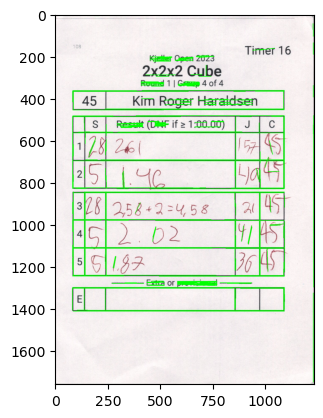